#DIGITAL IMAGE PROCESSING - PACKAGE

#DONE BY

> 19PD20 - M S VIJAYALAKSHMI

> 19PD34 - SNEHA P

# IMPORTING LIBRARIES

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline

#UPLOADING THE IMAGE AND EQUILIZING THE RGB CHANNELS

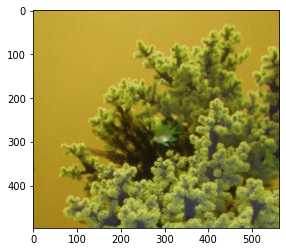

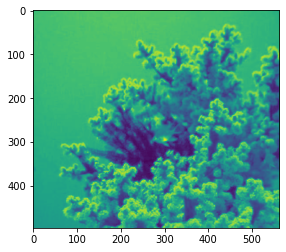

In [ ]:
img = cv2.imread("img.jpg")
plt.imshow(img)
plt.show()
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]
Rm=np.mean(R,axis=0)
rm1=np.mean(Rm);
Gm=np.mean(G,axis=0)
gm1=np.mean(Gm);
Bm=np.mean(B,axis=0);
bm1=np.mean(Bm);
Irc = np.double(R)+np.double((gm1-rm1))*np.double((1-rm1))*np.double(G)
plt.imshow(Irc)
plt.show()

#WHITE BALANCING

WE USE GRAYWORLD ALGORITHM TO WHITE BALANCE THE IMAGE

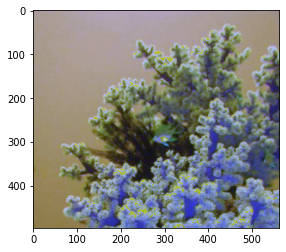

In [ ]:
def grayworld5():
    input1= cv2.imread('img.jpg');
    plt.imshow(input1)
    dim = np.shape(input1)[2];
    input1 = np.array(input1,dtype='uint8')
    output = np.zeros(np.shape(input1))
    if(dim==1 or dim==3):
        for j in range(0,dim):
            value1 = np.sum(np.sum(input1[:,:,j],axis=0),axis=0)
            value2 = np.size(input1[:,:,j])
            scalVal=value1/value2;
            sai=(127.5/scalVal);
            output[:,:,j]=input1[:,:,j]*sai;
        output = np.array(output,dtype='uint8');
        plt.imshow(output);
        cv2.imwrite('dim2.jpg',output)
    else:
        print('myApp:argChk','Input error. Matrix dimensions do not fit.');
    
    return output;
final_output=grayworld5()

#GAMMA CORRECTION AND SHARPENING

##GAMMA CORRECTION

ON THE WHITE BALANCED IMAGE WE APPLY GAMMA CORRECTION. HERE THE GAMMA VALUE USED IS 1.3

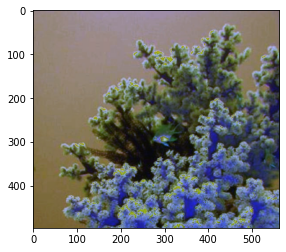

True

In [ ]:
img = cv2.imread('dim2.jpg')
gamma = 1.3
 
gamma_corrected = np.array(255*(img / 255) ** gamma, dtype = 'uint8')
plt.imshow(gamma_corrected)
plt.show()
cv2.imwrite('gamma_corrected.jpg',gamma_corrected)

##SHARPENING

WITH THE SAME WHITE BALANCED IMAGE WE APPLY SHARPENING FILTERS (HIGH PASS FILTERS) FOR EDGE DETECTION

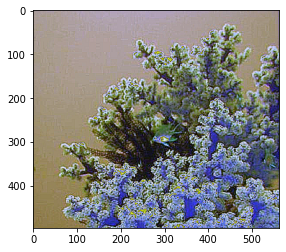

In [ ]:
img = cv2.imread('dim2.jpg')
filter1 = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])

sharpen_img = cv2.filter2D(img,-1,filter1)
cv2.imwrite('sharpen_image.jpg', sharpen_img)
plt.imshow(sharpen_img)
plt.show()

#MULTI-SCALE FUSION

## LAPLACIAN WEIGHT

In [ ]:
img = cv2.imread('sharpen_image.jpg',0)

def laplace_contrast_weight(src_gray):
    WL1= cv2.Laplacian(src_gray,cv2.CV_64F)
    abs_dst = cv2.convertScaleAbs(WL1)
    return abs_dst
out = laplace_contrast_weight(img)
print(out)

[[  4   6  25 ... 103  86  14]
 [  2  17  21 ... 120  88   9]
 [ 29  38  16 ... 130  85   8]
 ...
 [  7  25  38 ...  68  66 107]
 [ 50  93  48 ... 175  26  60]
 [104 115  62 ... 255 123  22]]


##GAUSSIAN MASK

In [ ]:
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

##SALIENCY WEIGHT

In [ ]:
def saliency_detection(img):
    kernel= np.array(matlab_style_gauss2D((3,3),1))
    gfrgb= cv2.filter2D(img,-1,kernel,cv2.BORDER_WRAP)
    lab= color.rgb2lab(gfrgb)
    l = np.double(lab[:,:,0])
    a = np.double(lab[:,:,1])
    b = np.double(lab[:,:,2])
    lm = np.mean(np.mean(l))
    am = np.mean(np.mean(a))
    bm = np.mean(np.mean(b))
    sm = np.square(l-lm)+ np.square(a-am) + np.square((b-bm))
    return sm

##PYRAMIDS

###GAUSSIAN AND LAPLACIAN PYRAMIDS

In [ ]:
def iexpand(image):
    out = None
    h= np.array([1,4,6,4,1])/16
    filt= (h.T).dot(h)
    outimage = np.zeros((image.shape[0]*2, image.shape[1]*2), dtype=np.float64)
    outimage[::2,::2]=image[:,:]
    out = cv2.filter2D(outimage,cv2.CV_64F,filt)
    return out

def ireduce(image):
    out = None
    h= np.array([1,4,6,4,1])/16
    filt= (h.T).dot(h)
    outimage = cv2.filter2D(image,cv2.CV_64F,filt)
    out = outimage[::2,::2]
    return out
 
def gaussian_pyramid(image, levels):
    output = []
    output.append(image)
    tmp = image
    for i in range(0,levels):
        tmp = ireduce(tmp)
        output.append(tmp)
    return output
  
def lapl_pyramid(gauss_pyr):
    output = []
    k = len(gauss_pyr)
    for i in range(0,k-1):
        gu = gauss_pyr[i]
        egu = iexpand(gauss_pyr[i+1])
        if egu.shape[0] > gu.shape[0]:
           egu = np.delete(egu,(-1),axis=0)
        if egu.shape[1] > gu.shape[1]:
          egu = np.delete(egu,(-1),axis=1)
        output.append(gu - egu)
    output.append(gauss_pyr.pop())
    return output

### BLENDING THE PYRAMIDS ACORDING TO MASK

In [ ]:
def blend(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask):
    blended_pyr = []
    k= len(gauss_pyr_mask)
    for i in range(0,k):
        p1= gauss_pyr_mask[i]*lapl_pyr_white[i]
        p2=(1 - gauss_pyr_mask[i])*lapl_pyr_black[i]
        blended_pyr.append(p1 + p2)
    return blended_pyr

def collapse(lapl_pyr):
    output = None
    output = np.zeros((lapl_pyr[0].shape[0],lapl_pyr[0].shape[1]), dtype=np.float64)
    for i in range(len(lapl_pyr)-1,0,-1):
        lap = iexpand(lapl_pyr[i])
        lapb = lapl_pyr[i-1]
        if lap.shape[0] > lapb.shape[0]:
          lap = np.delete(lap,(-1),axis=0)
        if lap.shape[1] > lapb.shape[1]:
          lap = np.delete(lap,(-1),axis=1)
        tmp = lap + lapb
    output = tmp
    return output

In [ ]:
def split_rgb(image):
    red = None
    green = None
    blue = None
    (blue, green, red) = cv2.split(image)
    return red, green, blue

###FUSSION OF THE GAMMA CORRECTED AND SHARPENED IMAGE TO GET DESIRED OUTPUT

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


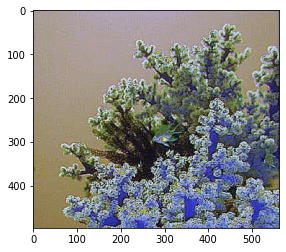

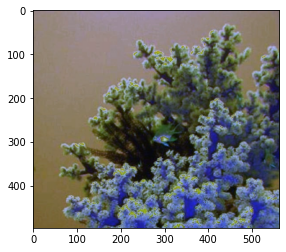

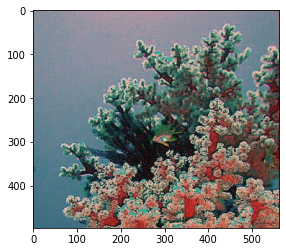

In [ ]:
img = cv2.imread('gamma_corrected.jpg');
im=cv2.imread('sharpen_image.jpg');
img1=np.array(img,dtype='uint8');
lab1=np.array(img,dtype='uint8');

img2=np.array(im,dtype='uint8');
lab2 = img2;
R1 = np.double(lab1[:,:,0])/255
R2 = np.double(lab2[:,:,0])/255

WL1= laplace_contrast_weight(R1)
WL2= laplace_contrast_weight(R2)

WS1= saliency_detection(img1)
WS2= saliency_detection(im)

sigma= 0.25
aver= 0.5
WE1= np.exp(-(R1-aver)**2/(2*np.square(sigma)))
WE2= np.exp(-(R2-aver)**2/(2*np.square(sigma)))

W1 = (WL1 + WS1 + WE1)/(WL1 + WS1 + WE1 + WL2 + WS2 + WE2)
W2 = (WL2 + WS2 + WE2)/(WL1 + WS1 + WE1 + WL2 + WS2 + WE2)

Weight1= gaussian_pyramid(W1,5)
Weight2= gaussian_pyramid(W2,5)

R1= None
G1= None
B1= None
R2= None
G2= None
B2= None

R_b= []
(R1,G1,B1)= split_rgb(img1)
(R2,G2,B2)= split_rgb(img2)



depth=5 
gauss_pyr_image1r = gaussian_pyramid(R1, depth)
gauss_pyr_image1g = gaussian_pyramid(G1, depth)
gauss_pyr_image1b = gaussian_pyramid(B1, depth)
 
gauss_pyr_image2r = gaussian_pyramid(R2, depth)
gauss_pyr_image2g = gaussian_pyramid(G2, depth)
gauss_pyr_image2b = gaussian_pyramid(B2, depth)


level=5
r1  = lapl_pyramid(gauss_pyr_image1r)
g1  = lapl_pyramid(gauss_pyr_image1g)
b1  = lapl_pyramid(gauss_pyr_image1b)
 
r2 = lapl_pyramid(gauss_pyr_image2r)
g2 = lapl_pyramid(gauss_pyr_image2g)
b2 = lapl_pyramid(gauss_pyr_image2b)

R_r = np.array(Weight1)* r1 + np.array(Weight2) * r2
R_g = np.array(Weight1)* g1 + np.array(Weight2) * g2
R_b = np.array(Weight1)* b1 + np.array(Weight2) * b2

R= collapse(R_r)
G= collapse(R_g)
B= collapse(R_b)


R[R < 0] = 0
R[R > 255] = 255
R = R.astype(np.uint8)
 
G[G < 0] = 0
G[G > 255] = 255
G = G.astype(np.uint8)
 
B[B < 0] = 0
B[B > 255] = 255
B = B.astype(np.uint8)
result = np.zeros(img.shape,dtype=img.dtype)
tmp = []
tmp.append(R)
tmp.append(G)
tmp.append(B)
result = cv2.merge(tmp,result)

plt.imshow(lab2)
plt.show()
plt.imshow(lab1)
plt.show()
plt.imshow(result)
plt.show()